In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.utils import to_categorical
# from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
# from keras import backend as objectives
from tensorflow.keras.losses import mse, binary_crossentropy
import skimage as sk
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
import os
from pathlib import Path
import cv2 as cv2
from tensorflow.python.framework.ops import disable_eager_execution
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
disable_eager_execution()

In [3]:
# data generator
# source from https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a

def get_input(path):
    """get specific image from path"""
    img = imread(path)
    return img

def preprocess_input(img):
    # convert between 0 and 1
    return img.astype('float32')

In [4]:
file_path = r"C:\Users\Saaqib\Documents\Imperial\Research Project\SWET_data"
img_path = []
files = os.listdir(file_path)
for root, directories, files in os.walk(file_path, topdown=False):
	for name in files:
		img_path.append(os.path.join(root, name))

In [9]:
x = []
y = []
for file_path in img_path[0:20]:
    input = get_input(file_path)
    input = cv2.resize(input, (2848,2136))
    input = sk.color.rgb2gray(input)
    input = preprocess_input(input)
    x.append(input)
    y.append(input)
x = np.array(x)
y = np.array(y)

# NOTE: some image sizes are smaller than the resize

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
x_train = x_train.reshape(-1,2136,2848,1)
x_test = x_test.reshape(-1,2136,2848,1)
y_train = x_train.reshape(-1,2136,2848,1)
y_test = x_test.reshape(-1,2136,2848,1)

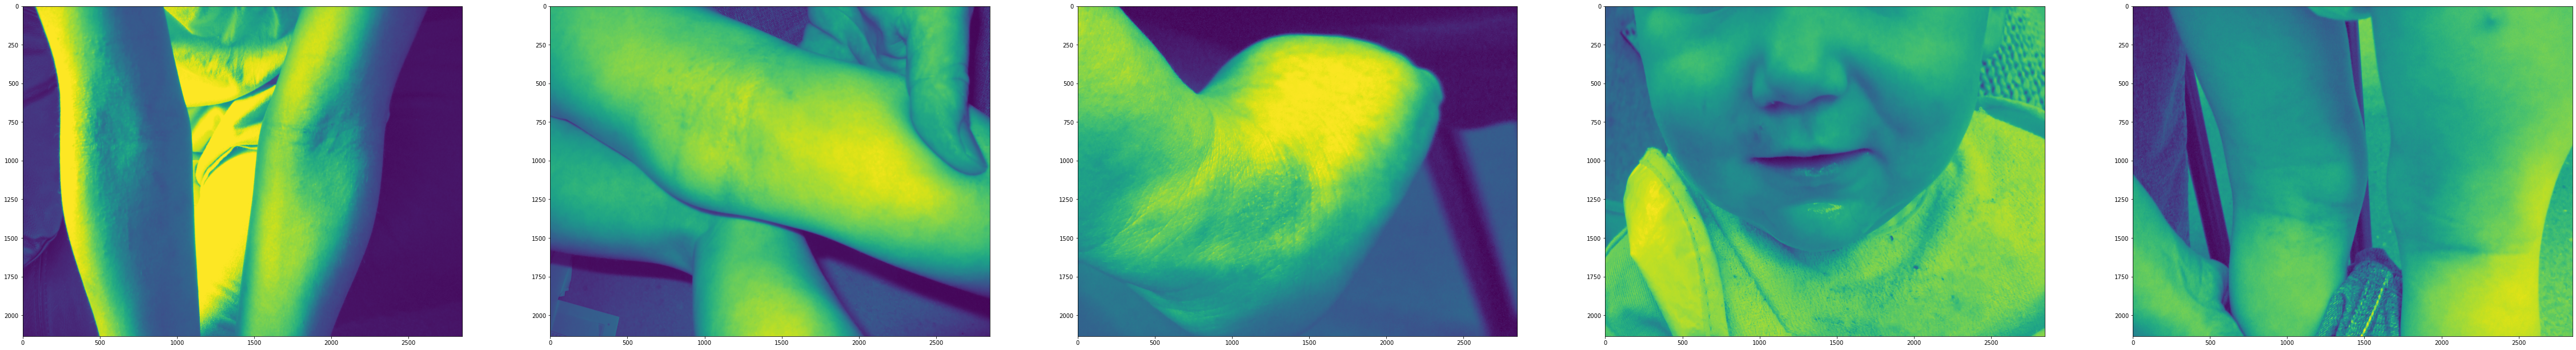

In [11]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(x_train[i, :, :, 0])

In [12]:
b_size = 128
n_size = 512
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape = (n_size,) , mean = 0, stddev = 1)
    return z_mean + K.exp(z_log_sigma/2) * epsilon
  
def build_conv_vae(input_shape, bottleneck_size, sampling, batch_size = 32):
    
    # ENCODER
    inputt = Input(shape=(input_shape[0],input_shape[1],input_shape[2]))
    x = Conv2D(32,(3,3),activation = 'relu', padding = 'same')(inputt)    
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(64,(3,3),activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(128,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    latent_view = MaxPooling2D((2,2), padding ='same')(x)
    
    # Latent Variable Calculation
    shape = K.int_shape(latent_view)
    
    flatten_1 = Flatten()(latent_view)
    dense_1 = Dense(bottleneck_size, name='z_mean')(flatten_1)
    z_mean = BatchNormalization()(dense_1)

    flatten_2 = Flatten()(latent_view)
    dense_2 = Dense(bottleneck_size, name ='z_log_sigma')(flatten_2)
    z_log_sigma = BatchNormalization()(dense_2)

    z = Lambda(sampling)([z_mean, z_log_sigma])
    encoder = Model(inputt, [z_mean, z_log_sigma, z], name = 'encoder')
    
    # DECODER
    latent_input = Input(shape=(bottleneck_size,), name = 'decoder_input')
    x = Dense(shape[1]*shape[2]*shape[3])(latent_input)
    x = Reshape((shape[1],shape[2],shape[3]))(x)
    x = UpSampling2D((2,2))(x)
    # x = Cropping2D([[0,0],[0,1]])(x)
    x = Conv2DTranspose(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    # x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(128,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    # x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(64,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    output = Conv2DTranspose(1,(3,3), activation = 'tanh', padding ='same')(x)

    decoder = Model(latent_input, output, name = 'decoder')

    output_2 = decoder(encoder(inputt)[2])
    vae = Model(inputt, output_2, name ='vae')

    vae_latent = Model(inputt, latent_view, name ='vae_latent')
    return vae, vae_latent, encoder, decoder, z_mean, z_log_sigma, z



In [13]:
# vae_2, encoder, decoder, z_mean, z_log_sigma = build_conv_vae((218,178,3), n_size, sampling, batch_size = b_size)
vae_2, vae_latent, encoder, decoder, z_mean, z_log_sigma,z = build_conv_vae((2136,2848,1), n_size, sampling, batch_size = b_size)


print("Encoder summary:")
encoder.summary()
print('Latent space summary:')
vae_latent.summary()
print("Decoder summary:")
decoder.summary()
print("vae summary:")
vae_2.summary()

Instructions for updating:
Colocations handled automatically by placer.
Encoder summary:
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2136, 2848,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 2136, 2848, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2136, 2848, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 1068, 1424, 3 0           batch_normalization[0][0]        
___

C:\Users\Saaqib\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\layer_utils.py:102: RuntimeWarning: overflow encountered in long_scalars
  return int(sum(np.prod(p) for p in standardized_weight_shapes))


In [14]:
def vae_loss(input_img, output):
    # Compute error in reconstruction
    reconstruction_loss = mse(K.flatten(input_img) , K.flatten(output))
    
    # Compute the KL Divergence regularization term
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
    
    # Return the average loss over all images in batch
    total_loss = (reconstruction_loss + 0.0001 * kl_loss)    
    return total_loss

In [15]:
vae_2.compile(optimizer='rmsprop', loss= vae_loss)
vae_latent.compile(optimizer='rmsprop', loss= vae_loss)
encoder.compile(optimizer = 'rmsprop', loss = vae_loss)
decoder.compile(optimizer = 'rmsprop', loss = vae_loss)

In [16]:
history = vae_2.fit(x_train, y_train,
                epochs=2,
                batch_size=128,
                validation_data=(x_test, y_test)).history


Train on 15 samples, validate on 5 samples
Epoch 1/2


InvalidArgumentError: Cannot parse tensor from proto: dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 6106112
  }
  dim {
    size: 512
  }
}
float_val: 0

	 [[node training/RMSprop/z_log_sigma/kernel/rms/Initializer/zeros (defined at \Local\Temp/ipykernel_14852/3607962345.py:1) ]]

Original stack trace for 'training/RMSprop/z_log_sigma/kernel/rms/Initializer/zeros':
  File "\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 667, in start
    self.io_loop.start()
  File "\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
    self._run_once()
  File "\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
    handle._run()
  File "\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 456, in dispatch_queue
    await self.process_one()
  File "\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 445, in process_one
    await dispatch(*args)
  File "\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 352, in dispatch_shell
    await result
  File "\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 647, in execute_request
    reply_content = await reply_content
  File "\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 345, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
    result = self._run_cell(
  File "\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
    return runner(coro)
  File "\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "\Local\Temp/ipykernel_14852/3607962345.py", line 1, in <module>
    history = vae_2.fit(x_train, y_train,
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training_v1.py", line 795, in fit
    return func.fit(
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py", line 644, in fit
    return fit_loop(
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py", line 181, in model_iteration
    f = _make_execution_function(model, mode)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py", line 551, in _make_execution_function
    return model._make_execution_function(mode)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training_v1.py", line 2097, in _make_execution_function
    self._make_train_function()
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training_v1.py", line 2028, in _make_train_function
    updates = self.optimizer.get_updates(
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py", line 773, in get_updates
    return [self.apply_gradients(grads_and_vars)]
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py", line 636, in apply_gradients
    self._create_all_weights(var_list)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py", line 823, in _create_all_weights
    self._create_slots(var_list)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\rmsprop.py", line 152, in _create_slots
    self.add_slot(var, "rms")
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py", line 909, in add_slot
    weight = tf_variables.Variable(
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variables.py", line 262, in __call__
    return cls._variable_v2_call(*args, **kwargs)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variables.py", line 244, in _variable_v2_call
    return previous_getter(
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variables.py", line 237, in <lambda>
    previous_getter = lambda **kws: default_variable_creator_v2(None, **kws)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2662, in default_variable_creator_v2
    return resource_variable_ops.ResourceVariable(
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\variables.py", line 264, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 1584, in __init__
    self._init_from_args(
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 1722, in _init_from_args
    initial_value = initial_value()
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\initializers\initializers_v2.py", line 151, in __call__
    return array_ops.zeros(shape, dtype)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py", line 206, in wrapper
    return target(*args, **kwargs)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2911, in wrapped
    tensor = fun(*args, **kwargs)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2960, in zeros
    output = _constant_if_small(zero, shape, dtype, name)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\array_ops.py", line 2897, in _constant_if_small
    return constant(value, shape=shape, dtype=dtype, name=name)
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\constant_op.py", line 264, in constant
    return _constant_impl(value, dtype, shape, name, verify_shape=False,
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\constant_op.py", line 286, in _constant_impl
    const_tensor = g._create_op_internal(  # pylint: disable=protected-access
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py", line 3557, in _create_op_internal
    ret = Operation(
  File "\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


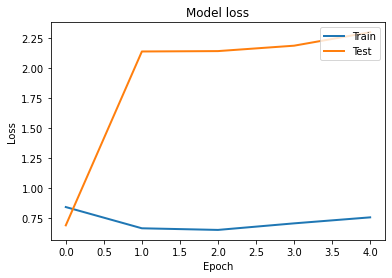

In [13]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

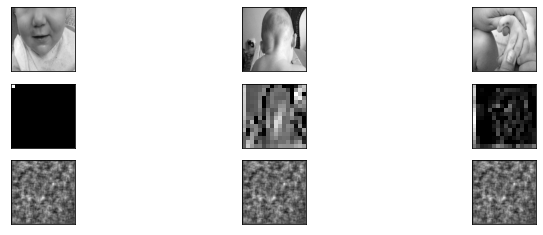

In [79]:
n = np.random.randint(0,len(y_test))
preds = vae_latent.predict(y_test)
pred = vae_2.predict(y_test)

plt.figure(figsize=(20, 4))
for i in range(3):
    # Display original
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[i].reshape(2816,2048))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display latent space
    ax = plt.subplot(3,5, i+1+5)
    plt.imshow(preds[i, :, :, i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(3, 5, i + 1 + 5+5)
    plt.imshow(pred[i].reshape(2816,2048))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# plt.show()
plt.savefig('vae_recon.png')

In [ ]:

# n = np.random.randint(0,len(y_test))
# preds = vae_latent.predict(y_test)
# pred = vae_2.predict(y_test)

# xtestdata = []
# latentspacedata = []
# preddata = []
# for i in range(5):
#     xtestdata.append(x_test[i])
#     latentspacedata.append(preds[i])
#     preddata.append(pred[i])

# print('xtestdata=',xtestdata)
# print('latentspacedata=',latentspacedata)
# print('preddata=',preddata)

In [ ]:
# n = np.random.randint(0,len(y_test))

# preds = model_latent.predict(y_test[n:n+4])

# f, ax = plt.subplots(2,2)
# ax = ax.ravel()
# for j in range(4):
#     for i,a in enumerate(range(n,n+3)):
#         ax[j].imshow(preds[i, :, :, j])
# plt.show()


In [ ]:
# pred = vae_2.predict(x_test)
# plt.figure(figsize=(20, 4))
# for i in range(5):
#     # Display original
#     ax = plt.subplot(2, 5, i + 1)
#     plt.imshow(x_test[i].reshape(2816,2048))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     # Display reconstruction
#     ax = plt.subplot(2, 5, i + 1 + 5)
#     plt.imshow(pred[i].reshape(2816,2048))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

In [ ]:
# x_test = []
# inpp = []
# for i in range(len(img_path)):
#     inp = get_input(img_path[i])
#     inp = preprocess_input(inp)
#     inp = cv2.resize(inp, (178,218))
#     inpp.append(inp)
#     # plt.imshow(inp)
# for i in range(len(inpp)):
#     x_test.append(inpp[random.randint(0,46)])
# x_test = np.array(x_test)
# figure_Decoded = vae_2.predict(x_test.astype('float32')/127.5 -1, batch_size = b_size)
# figure_original = x_test[0]
# figure_decoded = (figure_Decoded[0]+1)/2
# for i in range(4):
#     plt.axis('off')
#     plt.subplot(2,4,1+i*2)
#     plt.imshow(x_test[i])
#     plt.axis('off')
#     plt.subplot(2,4,2 + i*2)
#     plt.imshow((figure_Decoded[i]+1)/2)
#     plt.axis('off')
# plt.show()  